### EDA

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import chardet
from sklearn.model_selection import KFold, train_test_split, cross_val_score 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(style="white", color_codes=True)

data_root = "./data/"


In [2]:
dfTrain = pd.read_csv(os.path.join(data_root, 'train_offline.csv'))
dfTrain.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [3]:
dfTest = pd.read_csv(os.path.join(data_root, 'test_offline.csv'))
dfTest.head() # It belongs to classification problem due to label values

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,to_testset
0,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,0,True
1,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,True
2,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,-1,True
3,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,0,True
4,2029232,450,1532.0,30:5,0.0,20160530.0,NaN,0,True


In [4]:
dfTrain.shape

(1160742, 7)

In [5]:
dfTest.shape

(594142, 9)

In [6]:
dfTrain.info() # Data has only float, int and object
               # No variable column has null/missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160742 entries, 0 to 1160741
Data columns (total 7 columns):
User_id          1160742 non-null int64
Merchant_id      1160742 non-null int64
Coupon_id        746969 non-null float64
Discount_rate    746969 non-null object
Distance         1090916 non-null float64
Date_received    746969 non-null float64
Date             456709 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 62.0+ MB


In [7]:
dfTest.label.unique() #Target variable/Dependent variable is discrete and categorical in nature
                      #Label range from 0 to 1

array([ 0, -1,  1], dtype=int64)

In [8]:
dfTest.Distance.describe() #check relationship between label and distance

count    557965.000000
mean          1.648883
std           2.919379
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          10.000000
Name: Distance, dtype: float64

In [9]:
dfTest.label.value_counts() # label has most values in -1 and 1

-1    287829
 0    278222
 1     28091
Name: label, dtype: int64

In [10]:
f = open(os.path.join(data_root, 'column_description.csv'), 'rb')
print(chardet.detect(f.read(100))) # check encoding
dfColDesc = pd.read_csv(os.path.join(data_root, 'column_description.csv'), encoding='big5')
dfColDesc.head()

{'encoding': 'Big5', 'confidence': 0.99, 'language': 'Chinese'}


,Column,Description
0,User_id,用戶 ID
1,Merchant_id,商家 ID
2,Coupon_id,優惠券 ID (null 代表無優惠券消費)
3,Discount_rate,"優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元"
4,Distance,"用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 1..."


In [11]:
dfColDescEn = pd.read_csv(os.path.join(data_root, 'column_description_en.csv'))
dfColDescEn.head()

,Column,Description
0,User_id,User id
1,Merchant_id,shop/merchant id
2,Coupon_id,"Coupon id. If it is null, it means the transac..."
3,Discount_rate,"Discount rate, [0,1] means ratio of discount. ..."
4,Distance,Distance between users' most active regions an...


In [12]:
dfTest["label"].value_counts()

-1    287829
 0    278222
 1     28091
Name: label, dtype: int64

### Visualize

[matplotlib](https://blog.csdn.net/hohaizx/article/details/79101322)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


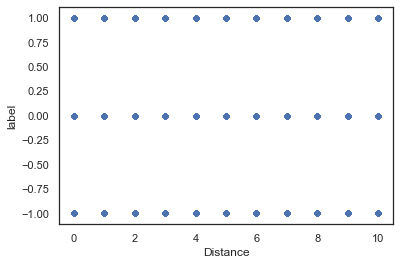

In [13]:
dfTest.plot(kind="scatter", x="Distance", y="label")

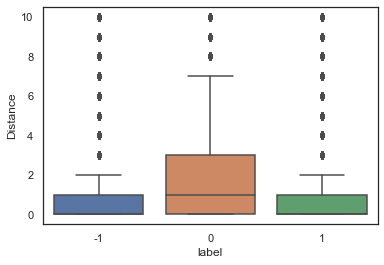

In [14]:
sns.boxplot(x="label", y="Distance", data=dfTest) # No matter how the distance is, users will use their coupon

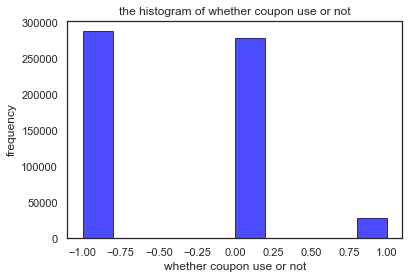

In [15]:
#dfTest["label"].hist()
#plt.hist(dfTest["label"]) 
#dfTest["label"].plot.hist(title = "title")

plt.hist(dfTest["label"], facecolor="blue", edgecolor="black", alpha=0.7)

plt.xlabel("whether coupon use or not")

plt.ylabel("frequency")

plt.title("the histogram of whether coupon use or not")

plt.show()


### Normalization

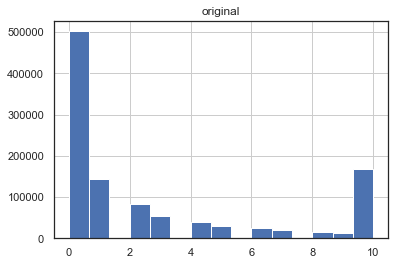

In [16]:
dfTrain["Distance"].hist(bins=15)
plt.title("original")
plt.show()

mean: 2.726183317505656  std: 3.6870647225019018


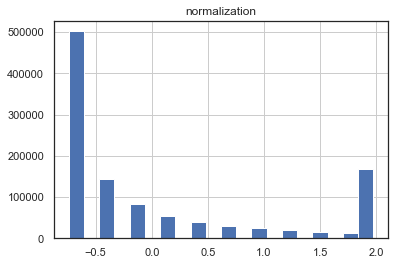

6         NaN
31        NaN
34        NaN
68        NaN
85        NaN
           ..
1160658   NaN
1160659   NaN
1160660   NaN
1160661   NaN
1160715   NaN
Name: Distance_normal1, Length: 69826, dtype: float64

In [17]:
#dfTrain["Distance_not_null"] = dfTrain[~dfTrain["Distance"].isnull()]["Distance"]

mean = np.mean(dfTrain[~dfTrain["Distance"].isnull()]["Distance"])
std = np.std(dfTrain[~dfTrain["Distance"].isnull()]["Distance"])
value = dfTrain["Distance"].values
print("mean:", mean, " std:", std)


dfTrain["Distance_normal1"] = ( value - mean ) / ( std )
                                                         
dfTrain["Distance_normal1"].hist(bins=20)
plt.title("normalization")
plt.show()

dfTrain[dfTrain["Distance_normal1"].isnull()]["Distance_normal1"]

### Data Prerocessing

In [18]:
def addB(row):
    return row + 1

In [19]:
df = pd.DataFrame({"A": [1, 2, 3, 4], "B": [5, 6, 7, 8], "C": [9, 10, 11, 12]})
df["A"] = df["A"].apply(lambda x : x + 5)

In [20]:
df["B"] = df["B"].apply(addB)

In [21]:
df.apply(np.sum, axis = 1)

0    21
1    24
2    27
3    30
dtype: int64

In [22]:
df.apply(np.sum)

A    30
B    30
C    42
dtype: int64

### Feature engineering

In [25]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):            
            return 1
    return 0

dfTrain["label"] = dfTrain.apply(label, axis=1)

dfTrain["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [27]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfTrain['weekday'] = dfTrain['Date_received'].apply(getWeekday)
dfTest['weekday'] = dfTest['Date_received'].apply(getWeekday)

In [28]:
dfTrain

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Distance_normal1,label,weekday
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-0.739391,-1,NaN
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,-0.739391,0,3.0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,-0.739391,0,6.0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,-0.739391,0,5.0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,-0.468173,0,5.0
...,...,...,...,...,...,...,...,...,...,...
1160737,212662,2934,5686.0,30:5,2.0,20160321.0,20160330.0,-0.196954,1,1.0
1160738,212662,3532,5267.0,30:5,1.0,20160322.0,NaN,-0.468173,0,2.0
1160739,212662,2934,5686.0,30:5,2.0,20160321.0,20160322.0,-0.196954,1,1.0
1160740,212662,3532,NaN,NaN,1.0,NaN,20160322.0,-0.468173,-1,NaN
